## Imports

In [ ]:
import leafmap
import geopandas as gpd
import rasterio
from rasterio.warp import calculate_default_transform, reproject, Resampling
from rasterio.features import rasterize
from rasterio.mask import mask
from rasterio.plot import show
import numpy as np
import matplotlib.pyplot as plt
import json
from shapely import wkt
from shapely.affinity import translate
from shapely.geometry import box
import torch
from samgeo import SamGeo, SamGeo2, raster_to_vector, overlay_images, 
#from samgeo.hq_sam import SamGeo, raster_to_vector, show_image, download_file, overlay_images, tms_to_geotiff
import gc
import os

## PyTorch Handling

In [12]:
torch.cuda.empty_cache()  # Clear GPU memory
torch.cuda.is_available()  # Check if CUDA is available
torch.cuda.memory_summary(device=None, abbreviated=False)  # Print memory summary
gc.collect()  # Run garbage collection to free up memory
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"
os.environ['PYTORCH_CUDA_ALLOC_CONF']='max_split_size_mb:256'
# Restart kernel to avoid memory issues

## Plotting Existing Masks

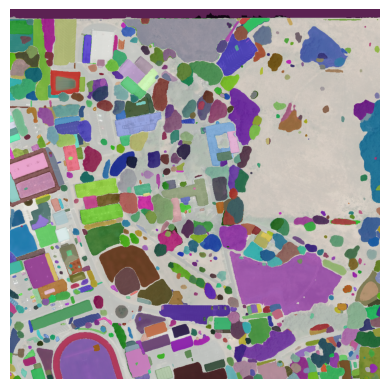

In [5]:
ann_img = rasterio.open("./annotations2.tif")
ann_img_data = ann_img.read([1,2,3])
ann_img_data = ann_img_data.transpose(1,2,0)

plt.imshow(ann_img_data)
plt.axis("off")
plt.show()

## SAM

In [3]:
sam_kwargs = {
    "points_per_side": 32,
    "points_per_batch": 8,
    "pred_iou_thresh": 0.86,
    "stability_score_thresh": 0.92,
    "crop_n_layers": 1,
    "crop_n_points_downscale_factor": 2,
    "min_mask_region_area": 80,
}

sam = SamGeo(
    model_type="vit_h",
    sam_kwargs=sam_kwargs,
)

In [ ]:
def split_image_into_quarters(image_path):
    with rasterio.open(image_path) as src:
        image = src.read()  # (C, H, W)
        meta = src.meta.copy()

    _, H, W = image.shape
    h_half, w_half = H // 2, W // 2

    # Define windows
    windows = {
        "top_left":    ((0, h_half),     (0, w_half)),
        "top_right":   ((0, h_half),     (w_half, W)),
        "bottom_left": ((h_half, H),     (0, w_half)),
        "bottom_right":((h_half, H),     (w_half, W))
    }

    # Extract quarters
    quarters = {}
    for key, ((r_start, r_end), (c_start, c_end)) in windows.items():
        quarters[key] = {
            "image": image[:, r_start:r_end, c_start:c_end],
            "origin": (c_start, r_start),  # x, y offset
            "bounds": box(c_start, r_start, c_end, r_end)
        }

    return quarters, meta

def run_sam_on_quarters(quarters, sam_function):
    """
    sam_function should take (H, W, 3) uint8 image and return a GeoDataFrame with polygon geometries.
    """
    mask_dfs = []

    for key, q in quarters.items():
        img = np.transpose(q['image'], (1, 2, 0))  # (H, W, C)

        # Run SAM
        masks_gdf = sam_function(img)

        # Shift geometries to full image coords
        x_off, y_off = q["origin"]
        masks_gdf['geometry'] = masks_gdf['geometry'].apply(lambda g: translate(g, xoff=x_off, yoff=y_off))
        mask_dfs.append(masks_gdf)

    # Combine masks from all quarters
    all_masks = gpd.GeoDataFrame(pd.concat(mask_dfs, ignore_index=True), crs=mask_dfs[0].crs)
    return all_masks


In [7]:
def split_into_nine_with_overlap(image_path, overlap_fraction=0.2):
    """
    Splits the image into 9 overlapping tiles with keys indicating relative positions.
    Each tile overlaps its neighbors by a specified fraction.

    Parameters:
        image_path (str): Path to the input image (.tif).
        overlap_fraction (float): Fraction of overlap between adjacent tiles.

    Returns:
        dict: Dictionary of tiles with keys like 'top_left', 'center', etc.
              Each entry contains 'image', 'row_bounds', 'col_bounds', 'transform'.
    """
    positions = [
        "top_left", "top_center", "top_right",
        "center_left", "center", "center_right",
        "bottom_left", "bottom_center", "bottom_right"
    ]
    
    with rasterio.open(image_path) as src:
        image = src.read()  # shape: (C, H, W)
        transform = src.transform
        height, width = image.shape[1], image.shape[2]
        
        third_h = height // 3
        third_w = width // 3
        overlap_h = int(third_h * overlap_fraction)
        overlap_w = int(third_w * overlap_fraction)

        # Define windows, row and column bounds
        windows = {
            "top_left":    ((0, third_h+overlap_h),     (0, third_w + overlap_w)),
            "top_center":  ((0, third_h+overlap_h),     (third_w - overlap_w, 2 * third_w + overlap_w)),
            "top_right":   ((0, third_h+overlap_h),     (2 * third_w - overlap_w, width)),
            "center_left": ((third_h-overlap_h, 2 * third_h + overlap_h), (0, third_w + overlap_w)),
            "center":      ((third_h-overlap_h, 2 * third_h + overlap_h), (third_w - overlap_w, 2 * third_w + overlap_w)),
            "center_right":((third_h-overlap_h, 2 * third_h + overlap_h), (2 * third_w - overlap_w, width)),
            "bottom_left": ((2 * third_h - overlap_h, height), (0, third_w + overlap_w)), 
            "bottom_center":((2 * third_h - overlap_h, height), (third_w - overlap_w, 2 * third_w + overlap_w)),
            "bottom_right":((2 * third_h - overlap_h, height), (2 * third_w - overlap_w, width))
        }
        

        tiles = {}
        for key, ((r_start, r_end), (c_start, c_end)) in windows.items():
            tiles[key] = {
                "image": image[:, r_start:r_end, c_start:c_end],
                "origin": (c_start, r_start),  # x, y offset
                "bounds": box(c_start, r_start, c_end, r_end)
            }

    return tiles


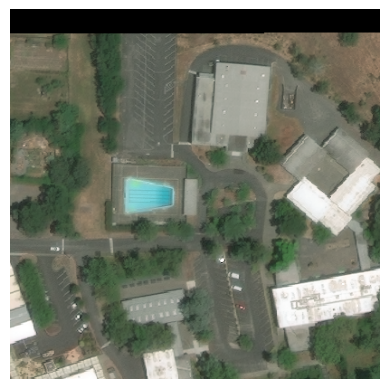

In [8]:
tiles = split_into_nine_with_overlap("norm_img.tif")


new_img = np.transpose(tiles["top_left"]['image'], (1,2,0))  # (H, W, C)
plt.imshow(new_img)
plt.axis("off")
plt.show()
    

In [11]:
sam.generate(new_img, output="mask_t.tif", foreground=False)
raster_to_vector("mask_t.tif", output="mask_t.shp")
sam.show_masks(cmap="binary_r")
sam.show_anns(axis="off", opacity=1, output="annotation_t.tif")

OutOfMemoryError: CUDA out of memory. Tried to allocate 1024.00 MiB. GPU 0 has a total capacity of 5.61 GiB of which 669.06 MiB is free. Including non-PyTorch memory, this process has 4.94 GiB memory in use. Of the allocated memory 4.75 GiB is allocated by PyTorch, and 90.42 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

## SAM2

In [ ]:
sam2 = SamGeo2(
    model_id="sam2-hiera-large",
    device="cuda",
    apply_postprocessing=False,
    points_per_side=32,
    points_per_batch=64,
    pred_iou_thresh=0.8,
    stability_score_thresh=0.92,
    stability_score_offset=0.7,
    crop_n_layers=4,
    crop_nms_thresh=0.8,
    crop_overlap_ratio=0.1,
    box_nms_thresh=0.9,
    crop_n_points_downscale_factor=1,
    min_mask_region_area=0.1,
    use_m2m=True,
)

In [3]:
sam2 = SamGeo2(
    model_id="sam2-hiera-large",
    device="cuda",
    apply_postprocessing=False,
    points_per_side=32,
    points_per_batch=64,
    pred_iou_thresh=0.8,
    stability_score_thresh=0.92,
    stability_score_offset=0.7,
    crop_n_layers=1,
    crop_nms_thresh=0.8,
    crop_overlap_ratio=0.1,
    box_nms_thresh=0.9,
    crop_n_points_downscale_factor=1,
    min_mask_region_area=5,
    use_m2m=True,
)

In [ ]:
sam2 = SamGeo2(
    model_id="sam2-hiera-large",
    apply_postprocessing=False,
    points_per_side=128,
    points_per_batch=64,
    pred_iou_thresh=0.85,
    stability_score_thresh=0.9,
    stability_score_offset=0.7,
    crop_n_layers=1,
    crop_nms_thresh=0.5,
    crop_overlap_ratio=0.1,
    box_nms_thresh=0.5,
    crop_n_points_downscale_factor=1,
    min_mask_region_area=25,
    use_m2m=True,
)

In [ ]:
sam2 = SamGeo2(
    model_id="sam2-hiera-large",
    apply_postprocessing=False,
    points_per_side=128,
    points_per_batch=64,
    pred_iou_thresh=0.7,
    stability_score_thresh=0.9,
    stability_score_offset=0.7,
    crop_n_layers=1,
    box_nms_thresh=0.7,
    crop_n_points_downscale_factor=2,
    min_mask_region_area=20,
    use_m2m=True,
)

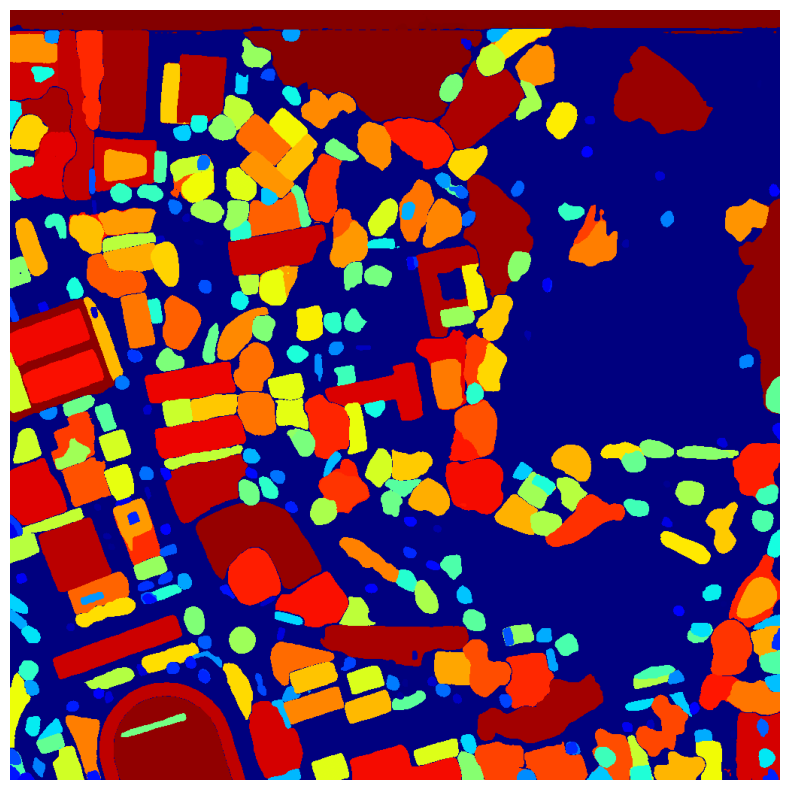

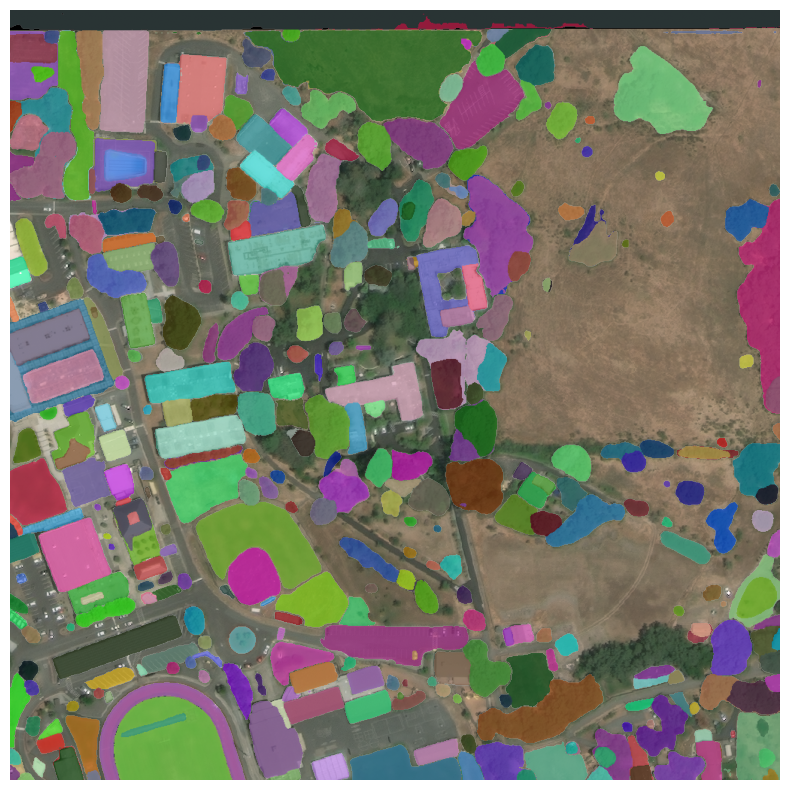

In [4]:
sam2.generate("norm_img.tif", output="masks_t2.tif")
raster_to_vector("masks_t2.tif", output="mask_t2.shp")
sam2.show_masks(cmap="jet")
sam2.show_anns(axis="off", alpha=0.6, output="annotations_t2.tif")

## Interactive Segmentation

In [5]:
import rasterio
with rasterio.open('norm_img.tif') as src:
    print(src.crs)


EPSG:4326


In [6]:
m = leafmap.Map()
m.add_raster('norm_img.tif', layer_name="Normalized Image", colormap='gray')
m

Map(center=[38.493840500000005, -122.738772], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom…

In [ ]:
sam = SamGeo2(
    model_id="sam2-hiera-large",
    automatic=False,
)

## Segmentation Masking

In [ ]:
def blacken_masked_regions(image_path, mask_gdf, output_path="masked_image.tif"):
    """
    Given a satellite image and a GeoDataFrame of polygon masks,
    blackens the masked regions in all bands and saves the result.

    Parameters:
        image_path (str): Path to the input image (GeoTIFF).
        mask_gdf (GeoDataFrame): Polygons representing existing masks.
        output_path (str): Path to save the new masked image.

    Returns:
        str: Path to the saved masked image.
    """
    with rasterio.open(image_path) as src:
        image = src.read()  # (bands, height, width)
        transform = src.transform
        meta = src.meta.copy()
        height, width = src.height, src.width

    # Rasterize mask_gdf to match image shape
    mask_raster = rasterize(
        [(geom, 1) for geom in mask_gdf.geometry],
        out_shape=(height, width),
        transform=transform,
        fill=0,
        dtype='uint8'
    )

    # Apply black mask across all bands
    masked_image = image.copy()
    for i in range(masked_image.shape[0]):
        masked_image[i][mask_raster == 1] = 0

    # Save new masked image
    meta.update({
        'dtype': masked_image.dtype,
        'count': masked_image.shape[0]
    })

    with rasterio.open(output_path, 'w', **meta) as dst:
        dst.write(masked_image)

    print(f"Masked image saved to: {output_path}")
    return output_path


In [ ]:
gdf = gpd.read_file("./Temporary_Data/mask3.shp")
print(gdf.head())

image_path = "norm_img.tif"
image_src = rasterio.open(image_path)

In [ ]:
blacken_masked_regions("norm_img.tif", gdf, output_path="masked_image.tif")

In [ ]:
with rasterio.open("masked_image.tif") as src:
    img = src.read([1, 2, 3])  # Read RGB bands
    img = img.transpose(1, 2, 0)  # Transpose to
    plt.figure(figsize=(10, 10))
    plt.imshow(img)
    plt.axis("off")
    plt.title("Masked Image")
    plt.show()

In [ ]:
fig, ax = plt.subplots(figsize=(10, 10))
show(image_src, ax=ax)
gdf.boundary.plot(ax=ax, edgecolor="red")
plt.show()